## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
!pwd

/global/cscratch1/sd/lheagy/heagy-2019-casing-ml/notebooks


In [2]:
# !pip install -r ../requirements.txt

In [3]:
# core python
import dask
import numpy as np
import datetime
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

## model parameters

In [4]:
simDir = "TDEM_fields_response_1km"

In [5]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 
# csz=1.25

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [6]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [7]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [8]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [9]:
print(model.diffusion_distance(1))


12615.6626101008


In [10]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

### create "approximate" models
- treat the well as a solid cylinder
- use a conductivity equal to that product of the conductivity and cross-sectional area of the casing
- to approximate the permeability, I preserve the product of the permeability and the thickness of the casing wall

In [11]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

model_solid_steel = model_approx_casing.copy()
model_solid_steel.sigma_inside = model.sigma_casing
model_solid_steel.sigma_casing = model.sigma_casing
model_solid_steel.filename = "solid_steel.json"

The approximate conductivity of the solid we use is 1.8e+06


keep track of the models in a dictionary

In [12]:
model_names = ["casing", "approx_casing", "solid_steel"] 
models = [model, model_approx_casing, model_solid_steel]
model_dict = dict(zip(
    model_names, 
    models 
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [13]:
model.diffusion_distance()

5701.1071274119095

In [14]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [15]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
#     npadx = 10, 
#     npadz = 19,
    csz = csz,
)
# meshGen.save()

In [16]:
mesh = meshGen.mesh

In [17]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


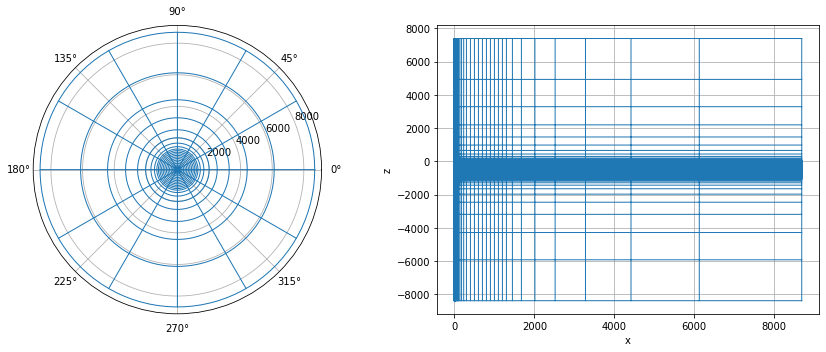

In [18]:
ax = mesh.plotGrid()

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [19]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


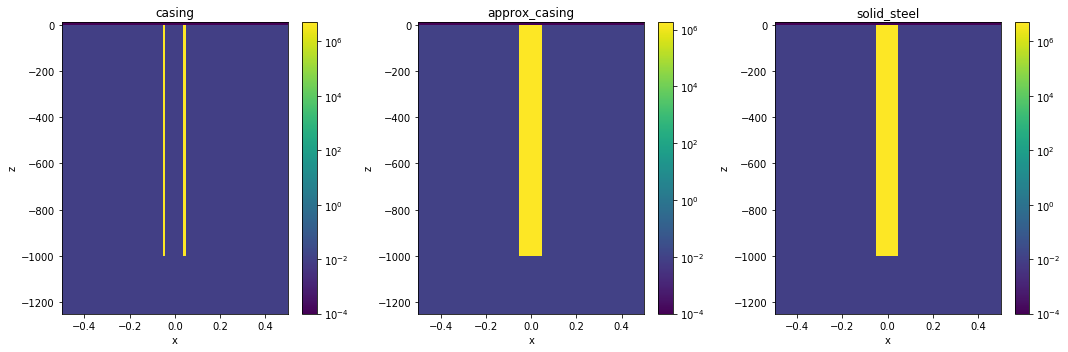

In [20]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

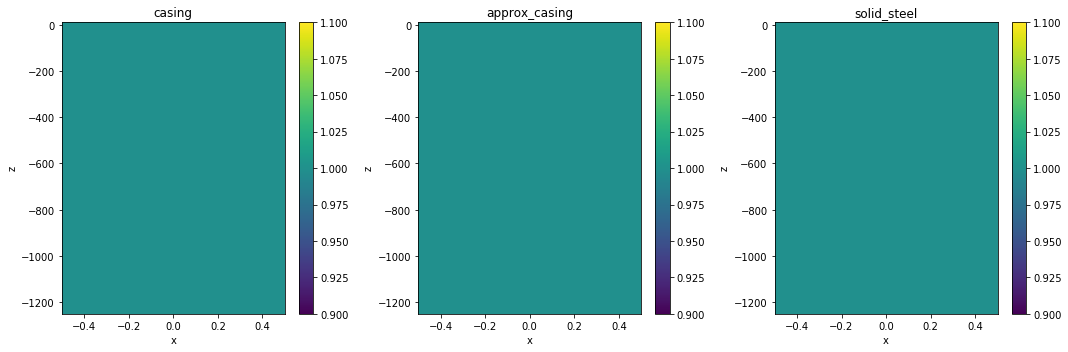

In [21]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [22]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [23]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [24]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [25]:
src_top = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    directory=simDir, 
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [26]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    directory=simDir,
    sources = sources  
)

source_list = casingSimSrcList.srcList

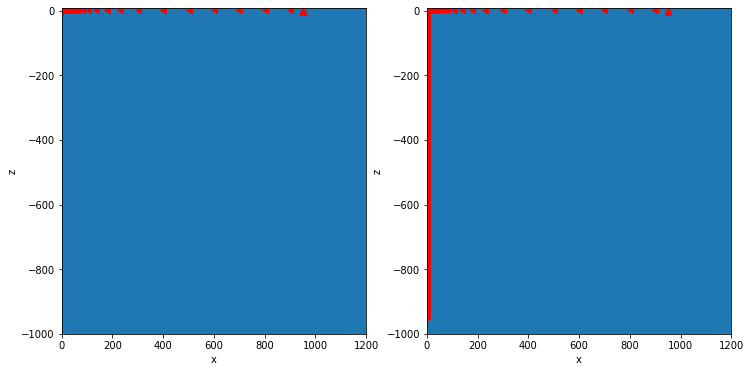

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [58]:
run = False

In [28]:
survey = tdem.Survey(source_list)

In [29]:
sim = tdem.Problem3D_j(
    mesh=mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Pardiso,
    time_steps=timeSteps
)

In [30]:
import dask
import dask_jobqueue
from dask.distributed import Client
from dask.diagnostics import ProgressBar

In [31]:
len(model_names)*16

48

In [32]:
cluster = dask_jobqueue.SLURMCluster(
    cores=len(model_names),
    processes=len(model_names), memory=f'{32*len(model_names)}GB', 
    project="m3384",
    job_extra = ['--constraint=haswell', '--qos=debug',], 
    death_timeout=120,
)

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [33]:
# dask_jobqueue.SLURMCluster??

In [34]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=3
#SBATCH --mem=90G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug
JOB_ID=${SLURM_JOB_ID%;*}



/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.49:38751 --nthreads 1 --nprocs 3 --memory-limit 32.00GB --name dask-worker--${JOB_ID}-- --death-timeout 120



In [35]:
client = Client(cluster)
client

# client = Client(threads_per_worker=3, n_workers=1)
# client

Client Scheduler: tcp://128.55.224.49:38751 Dashboard: http://128.55.224.49:37107/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [36]:
# @dask.delayed
def run_simulation(m, simulation_params, directory=None, name=None):
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from pymatsolver import Pardiso
        
    if isinstance(simulation_params, str):
        simulation_params = json.loads(simulation_params)
    
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    
    if isinstance(m, str):
        model = casing_sim.model.CasingInHalfspace.deserialize(json.loads(m), trusted=True)
        m = model.sigma(sim.mesh)
    
    sim.solver = Pardiso
    sim.verbose = True
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
    if name is not None: 
        filename = f"{name}.npy"
        tosave = os.path.sep.join([directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    return tosave

In [37]:
cluster.scale(3)

In [38]:
f = {}
for key, value in physprops_dict.items():
    time = datetime.datetime.now()
    model = model_dict[key]
    directory = f"{time.year}{time.month}{time.day}{time.hour}{os.path.sep}{int(model.casing_l)}m_sigma{model.sigma_back:1.0e}"
    
    if not os.path.isdir(directory):
        os.makedirs(directory, exist_ok=True)
    
    model.save(f"{key}.json", directory)
    
    f[key] = dask.delayed(run_simulation)(
        value.sigma, sim.serialize(), directory, key
    )
    
    

Saved 20198413/1000m_sigma1e-02/casing.json
Saved 20198413/1000m_sigma1e-02/approx_casing.json
Saved 20198413/1000m_sigma1e-02/solid_steel.json


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [39]:
f

{'casing': Delayed('run_simulation-dd3c952a-7f98-4b45-8562-dd1cd348cf8a'),
 'approx_casing': Delayed('run_simulation-c2133ad6-c2fe-4a2e-b466-d61450842264'),
 'solid_steel': Delayed('run_simulation-d4994954-252d-4066-acf4-7430c69c0c5f')}

In [40]:
%%time
if run is True: 
    fields_files = dask.compute(f)

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1min 9s, sys: 5.99 s, total: 1min 15s
Wall time: 28min 41s


load the results into memory and re-populate the fields object (this takes a couple minutes). 

In [41]:
fields_dict

({'casing': '20198413/1000m_sigma1e-02/casing.npy',
  'approx_casing': '20198413/1000m_sigma1e-02/approx_casing.npy',
  'solid_steel': '20198413/1000m_sigma1e-02/solid_steel.npy'},)

In [44]:
solution_dict = {}
for key, val in fields_dict[0].items():
    solution_dict[key] = np.load(val)

In [54]:
m = model_dict['casing']

#### todo: profile this at some point - the fields object should not be this expensive to create

In [56]:
fields_dict = {}

for key, val in solution_dict.items():
    print(key)
    sim.model = model_dict[key].sigma(sim.mesh)
    fields_dict[key] = sim.fieldsPair(sim)
    fields_dict[key][:, 'jSolution', :] = solution_dict[key]

casing


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


approx_casing
solid_steel


In [59]:
# sim_dict = {}
# for key in model_names:
#     sim_dict[key] = sim.copy()
#     sim_dict[key].modelParameters = model_dict[key]
#     sim_dict[key].srcList = sim.srcList

# mesh = sim_dict["casing"].meshGenerator.mesh

In [60]:
import casingSimulations as casingSim

In [66]:
viewer = casingSim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict={key: sim.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

SyntaxError: positional argument follows keyword argument (<ipython-input-66-5187cf4f362c>, line 3)

In [64]:
casingSim.FieldsViewer??

Init signature: casingSim.FieldsViewer(*args, **kwargs)
Docstring:     
**Required Properties:**

* **eps**: small value to add to colorbar so it is not strictly zero for logarithmic fields, a float, Default: 1e-20
* **primary_key**: key indicating which model we treat as the primary, a unicode string
Source:        
class FieldsViewer(properties.HasProperties):

    eps = properties.Float(
        "small value to add to colorbar so it is not strictly zero for "
        "logarithmic fields",
        default=1e-20
    )

    # todo: we should also allow this to be a dict
    primary_key=properties.String(
        "key indicating which model we treat as the primary"
    )

    def __init__(
        self, mesh, model_parameters_dict, survey_dict, fields_dict, model_keys=None,
        **kwargs
    ):
        super(FieldsViewer, self).__init__(**kwargs)
        # self.sim_dict = sim_dict
        self.model_parameters_dict = model_parameters_dict
        self.mesh = mesh
        self.survey_

In [ ]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [ ]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [ ]:
viewer.primary = "casing"

In [ ]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

## Plan View 

In [ ]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [ ]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6}, 
    defaults={
        "max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing", 
        "use_aspect":True, "theta_shift":mesh.hy[0]/2, "k":10
    }
)

In [ ]:
%%time
data_time = {}

xmin=5 
xmax=1000 
rx_times=fields_dict[key].survey.prob.timeMesh.gridN

# indices to grab
e_tz_inds = (
    (mesh.gridFx[:, 0]>=xmin) & (mesh.gridFx[:, 0]<=xmax) & 
    (mesh.gridFx[:, 1] == mesh.vectorCCy[0]) & 
    (mesh.gridFx[:, 2] == -csz/2.)
)

x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
x = rx_x = mesh.vectorNx[x_inds]

time_inds = discretize.utils.closestPoints(fields_dict[model_names[0]].survey.prob.timeMesh, rx_times, 'N')
t = times = fields_dict[model_names[0]].survey.prob.timeMesh.gridN[time_inds]

for key in model_names:    
    if key not in data_time.keys():
        print(f"fetching {key}")
        f = fields_dict[key]
        data = []       
    
    for src_ind in range(len(f.survey.srcList)):
        e_data = f[f.survey.srcList[src_ind], 'e', time_inds]
        e_data = (e_data[:mesh.vnF[0], :])[e_tz_inds, :]  
        e_data = e_data.reshape(len(rx_x), len(times), order="F")
        data += [e_data]
    
    data_time[key] = data

In [ ]:
%%time

dbdt_time = {}


dbdt_tz_inds = (
    (mesh.gridEy[:, 0]>=xmin) & (mesh.gridEy[:, 0]<=xmax) & 
    (mesh.gridEy[:, 1] == mesh.vectorCCy[0]) & 
    (mesh.gridEy[:, 2] == 0)
)

x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
x = rx_x = mesh.vectorNx[x_inds]

time_inds = discretize.utils.closestPoints(fields_dict[model_names[0]].survey.prob.timeMesh, rx_times, 'N')
t = times = fields_dict[model_names[0]].survey.prob.timeMesh.gridN[time_inds]

for key in ["background", "casing", "permeable"]:
    if key not in dbdt_time.keys():
        print(f"fetching {key}")
        f = fields_dict[key]
        data = []

        for src_ind in range(len(f.survey.srcList)):
            dbdt_data = f[f.survey.srcList[src_ind], 'dbdt', time_inds]
            dbdt_data = (dbdt_data[mesh.vnE[0]:mesh.vnE[:2].sum(), :])[dbdt_tz_inds, :]
            dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
            data += [dbdt_data]

        dbdt_time[key] = data


In [ ]:
from matplotlib import colors
from matplotlib import cm as cmap

In [ ]:
rx_times = np.logspace(np.log10(1e-5), np.log10(0.05), 10)
time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, rx_times, 'N')
times = fields_dict["casing"].survey.prob.timeMesh.gridN[time_inds]
print(times)

In [ ]:
cm = plt.get_cmap('magma')
key = "casing"
c_norm = colors.LogNorm(vmin=times.min(), vmax=times.max()*6)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

c_norm_msec = colors.LogNorm(vmin=times.min()*1e3, vmax=times.max()*6*1e3)
scalar_map_msec = cmap.ScalarMappable(norm=c_norm_msec, cmap=cm)
scalar_map_msec.set_array([])

In [ ]:
from string import ascii_lowercase
from matplotlib import rcParams

rcParams['font.size'] = 14

In [ ]:
def plot_data(x, data, color, ax, plot_sign=False, ls='-', lw=1, ms=2, plot_type="semilogy", label=None):
    
    if plot_sign is True:
        pos = data >= 0   
        split_me = np.hstack([np.r_[0], np.where(np.diff(pos))[0], np.r_[len(pos) - 1]])
        for i, s in enumerate(split_me[:-1]):
            xplt = x[s:split_me[i+1]+2]
            dplt = data[s:split_me[i+1]+2]
            if i == 0:
                ax.plot(np.r_[np.NaN], np.r_[np.NaN], '-', color=color, label=label, lw=lw)
            if pos[s+1] == True: 
                getattr(ax, plot_type)(xplt, dplt, '-', color=color, lw=lw)
            elif pos[s+1] == False:
                getattr(ax, plot_type)(xplt, -dplt, '--', color=color, lw=lw)
    else:
        getattr(ax, plot_type)(x, np.absolute(data), ls, color=color, label=label, lw=lw, ms=ms)

In [ ]:
print(model_dict["casing"].src_a)
print(np.pi/2 + mesh.hy[0]/2)

In [ ]:
demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, [1e-5, 1e-4], 'N')
demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

In [ ]:
viewerplt = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="background"
)

In [ ]:
demo_time_inds

## So much plotting code!

In [ ]:
z_ind_default = 409 if use_downsampled else 421
def plot_data_overview(
    key1="background", key2="casing", data="e", times=[1e-5, 1e-3], 
    include_percent=True,  
    d_ylim=None, clim=None,
    percent_lim=np.r_[0., 35], xlim=1200*np.r_[-1, 1], src_ind=0, z_ind=z_ind_default, x_ind=15
):
    viewerplt = casingSim.FieldsViewer(
        model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key=key1
    )
    
    plt_inds = (t > 1e-5) & (t < 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]
    
    if d_ylim is not None: 
        eps=1e-3*d_ylim[0]
    else:
        eps = 0. 
    
    # data
    if data=="e":
        ddict = data_time
    elif data =="dbdt":
        ddict = dbdt_time
        
    # times
    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

    # plotting controls
    ylim = xlim
    stream_opts={"arrowsize":1.4, "color":"k", "density":0.85}
    
    # create the figure 
    if include_percent is True: 
        fig = plt.figure(figsize=(16, 13)) 
        gs = gridspec.GridSpec(4, 5, width_ratios=[1, 1, 0.35, 1.5, 1.5], hspace=0.25, wspace=0.1) 
        ax = np.array([plt.subplot(gs[i]) for i in range(4*5)]).reshape(5, 4, order="F")
    else: 
        fig = plt.figure(figsize=(16, 10)) 
        gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 0.35, 1.5, 1.5], hspace=0.25, wspace=0.1) 
        ax = np.array([plt.subplot(gs[i]) for i in range(3*5)]).reshape(5, 3, order="F")

    for ii, time in enumerate(demo_times):
        i = demo_time_inds[ii]
        color=tcolors[ii]

        # plot data
        dd = [
            ddict[key1][src_ind][:, i], 
            ddict[key2][src_ind][:, i], 
            ddict[key2][src_ind][:, i]-ddict[key1][src_ind][:, i], 
        ]
        if include_percent:
            dd += [(ddict[key2][src_ind][:, i]-ddict[key1][src_ind][:, i])/(np.absolute(ddict[key1][src_ind][:, i])+eps)*100]
        
        label = "{:0.2f} ms".format(time*1e3)
        for a, d in zip(ax[3, :], dd):
            plot_type = "semilogy"
            if include_percent == True:
                if a == ax[3, 3]:
                    plot_type = "plot"
                    
            plot_data(
                x, d, color, a, plot_sign=True, label=label,
                plot_type=plot_type
            )
            label=None

            if include_percent: 
                if a == ax[3, 3]:
                    a.plot(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
                else: 
                    a.semilogy(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
            else: 
                a.semilogy(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
                
        # plot plan-view at the surface
        out = []
        for a, primsec in zip(ax[ii, :], ["primary", "total", "secondary"]):
            out += [
                viewerplt.plot_depth_slice(
                    xlim=xlim, ylim=xlim, clim=clim if primsec != "percent" else percent_lim, 
                    ax=a, z_ind=z_ind, model_key=key2, view=data,
                    show_cb=False, time_ind=i, rotate=True, theta_shift=mesh.hy[0]/2,
                    stream_opts=stream_opts, prim_sec=primsec, src_ind=src_ind
            )]

 # plot data through time
    dd = [
            ddict[key1][src_ind][x_ind, :], 
            ddict[key2][src_ind][x_ind, :], 
            ddict[key2][src_ind][x_ind, :]-ddict[key1][src_ind][x_ind, :], 
    ]
    if include_percent:
        dd += [
            (ddict[key2][src_ind][x_ind, :]-ddict[key1][src_ind][x_ind, :])/(np.absolute(ddict[key1][src_ind][x_ind, :])+eps)*100
        ]
        
    label = "{:1.0f} m".format(x[x_ind])
    for a, d in zip(ax[4, :], dd):
        plot_type = "loglog"
        if include_percent == True:
            if a == ax[4, 3]:
                plot_type = "semilogx"
                
        plot_data(
            tplt*1e3, d[plt_inds], tcolor, a, plot_sign=True, 
            plot_type=plot_type,
            label=label
        )
        label=None
        for ii, time in enumerate(demo_times):
            i = demo_time_inds[ii]
            color=tcolors[ii]    #scalar_map.to_rgba(time)
            if include_percent:
                if a == ax[4, 3]:
                    a.semilogx(time*1e3, np.absolute(d[i]), 'o', color=color)
                else: 
                    a.loglog(time*1e3, np.absolute(d[i]), 'o', color=color)
            else:
                a.loglog(time*1e3, np.absolute(d[i]), 'o', color=color)


    for ii, a in enumerate(ax[[0, 1], 0]):
        a.text(xlim[1]-100, xlim[0]+200, "{:0.2f} ms".format(demo_times[ii]*1e3), color='w', fontsize=22, ha="right")


    ax[3, 0].legend()
    ax[4, 0].legend()

    [a.set_axis_off() for a in ax[2, :]]
    [a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate((ax[[0, 1, 3, 4], :].T).flatten())]   

    
    for i, a in enumerate(ax[4, :]):
        a.grid(which="both", alpha=0.4, lw=0.5)
#         a.set_title('({})'.format(ascii_lowercase[i*4 +3]))
        a.set_yticklabels(['']*len(a.get_yticklabels()))
        a.set_ylabel('')
        a.set_ylim(d_ylim)
        
        if (i < 3 and include_percent == True) or (i < 2 and include_percent == False):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            
        else:
            a.set_xlabel('time (ms)')
            if include_percent == True: 
                a.set_ylim(percent_lim)

    for i, a in enumerate(ax[3, :]):
        if i < 3: 
            a.set_ylim(d_ylim)
        else:
            a.set_ylim(percent_lim)
            
        a.grid(which="both", alpha=0.4, lw=0.5)
#         a.set_title('({})'.format(ascii_lowercase[i*4 +2]))
        
        if (i < 3 and include_percent == True) or (i < 2 and include_percent == False):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
        else:
            a.set_xlabel('offset (m)')

        if i in [0, 1]: 
            a.set_ylabel(
                '$db/dt$ (V/m$^2$)' if data == "dbdt" else 
                'electric field, E$_r$ (V/m)'
            )
    #         a.legend()
        elif i == 2: 
            a.set_ylabel(
                'difference, $db/dt$ (V/m$^2$)' if data == "dbdt" else
                'difference, E$_r$ (V/m)'
            )
        else: 
            a.set_ylabel(
                'difference, $db/dt$ (%)' if data == "dbdt" else
                'difference, E$_r$ (%)'
            )
            

    for j, aa in enumerate([ax[0, :3], ax[1, :3]]):
        for i, a in enumerate(aa):
            if i < 2:
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')
            else:
                a.set_xlabel('x (m)')

            if j > 0: 
                a.set_yticklabels(['']*len(a.get_yticklabels()))
                a.set_ylabel('')
            else:
                a.set_ylabel("y (m)")

            a.plot(np.r_[0., 0], np.r_[0, 1000], 'w--')
            a.plot(np.r_[0], x[x_ind], "o", color=tcolor)

    if include_percent: 
        for a in ax[:2, -1]:
            a.set_axis_off() 
            a.set_title('')
        ax[3, -1].set_title("(m)")
        ax[4, -1].set_title("(n)")


        cbar_ax = fig.add_axes([0.15, 0.25, 0.22, 0.01])
    else:
        cbar_ax = fig.add_axes([0.15, 0.025, 0.22, 0.01])
        
    cb = plt.colorbar(out[0][0], cbar_ax, orientation="horizontal")
    cb.set_label('$db/dt$ (V/m$^2$)' if data=="dbdt" else 'Electric field (V/m)')
    

    return fig, ax

In [ ]:
fig, ax = plot_data_overview(
    "background", "casing", "e", times=[1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], include_percent=False
)

if use_downsampled is False: 
    fig.savefig("../figures/surface_e_fields_overview", dpi=250,  bbox_inches="tight")



In [ ]:
# the calculation of b on the downsampled results is not accurate as we are not satisfying boundary conditions 
# for the curl.  
if use_downsampled is False: 
    fig, ax = plot_data_overview(
        "background", "casing", "dbdt", times=[1e-5, 5e-3],
        d_ylim=np.r_[1e-11, 1e-4], clim=np.r_[1e-11, 1e-4], percent_lim = np.r_[0, 35], 
        include_percent=True
    )


    fig.savefig("../figures/surface_dbdt_overview", dpi=250,  bbox_inches="tight")



In [ ]:
fig, ax = plot_data_overview(
    "casing", "permeable", "e", 
    times = [1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 250],
    include_percent=True
)

if use_downsampled is False: 
    fig.savefig("../figures/surface_e_fields_permeable", dpi=250,  bbox_inches="tight")



In [ ]:
# the calculation of b on the downsampled results is not accurate as we are not satisfying boundary conditions 
# for the curl. 
if use_downsampled is False: 
    fig, ax = plot_data_overview(
        "casing", "permeable", "dbdt", times=[1e-5, 5e-3],
        d_ylim=np.r_[1e-11, 1e-4], clim=np.r_[1e-11, 1e-4], percent_lim = np.r_[0, 60], 
        include_percent=True
    )

    fig.savefig("../figures/surface_dbdt_permeable", dpi=250,  bbox_inches="tight")



In [ ]:
if use_downsampled is False:
    
    # I only saved the top-casing source results in the downsampled fields, this plot looks at the downhole source 
    fig, ax = plot_data_overview(
        "casing", "permeable", "e", 
        times = [1e-5, 5e-3], 
        d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 450],
        include_percent=True, src_ind=1
    )

 
    fig.savefig("../figures/surface_e_fields_permeable_downhole", dpi=250,  bbox_inches="tight")



In [ ]:
if include_approximate is True: 
    fig, ax = plot_data_overview(
        "casing", "approx_casing", "e", 
        times = [1e-5, 5e-3], 
        d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 10],
        include_percent=True, src_ind=0
    )

    if use_downsampled is False:
        fig.savefig("../figures/surface_e_fields_approx_casing", dpi=250, bbox_inches="tight")



In [ ]:
if include_approximate is True: 
    fig, ax = plot_data_overview(
        "permeable", "approx_permeable", "e", 
        times = [1e-5, 5e-3], 
        d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 25],
        include_percent=True, src_ind=0
    )

    if use_downsampled is False:
        fig.savefig("../figures/surface_e_fields_approx_permeable", dpi=250, bbox_inches="tight")



In [ ]:
def plot_currents(
    key1="background", key2="casing", times=[1e-5, 1e-3], 
    include_percent=True, 
    d_ylim=None, clim=None,
    percent_lim=np.r_[0., 35], xlim=1200*np.r_[-1, 1], src_ind=0, z_ind=421, x_ind=15
):
    viewerplt = casingSim.FieldsViewer(
        model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key=key1
    )
    
    plt_inds = (t > 1e-5) & (t < 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]
    
    if d_ylim is not None: 
        eps=1e-3*d_ylim[0]
    else:
        eps = 0. 
    
    # data
    if data=="e":
        ddict = data_time
    elif data =="dbdt":
        ddict = dbdt_time
        
    # times
    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

In [ ]:
mod = model.copy()
mod.casing_d = model.casing_b
mod.casing_t = model.casing_b

mod2 = mod.copy()
mod2.casing_l = csz
mod2.casing_top = -500 + csz/2.
mod2.casing_z

In [ ]:

# fig.subplots_adjust(hspace=0.1)
def plot_currents_overview(key1="casing", key2="approx_casing", times=[1e-5, 5e-3], ylim=[3e-7, 1], ylim_percent=[-1, 20]):

    fig, ax = plt.subplots(4, 2, figsize = (12, 12))
    src1 = sim_dict[key1].srcList.srcList[0]
    src2 = sim_dict[key2].srcList.srcList[0]

    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

    plt_inds = (t >= 1e-5) & (t <= 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]


    for ii, time in enumerate(demo_times):
        i = demo_time_inds[ii]
        color=tcolors[ii]

        z_currents, iz1 = casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod)["z"]
        z_currents, iz2 = casingSim.casing_currents(fields_dict[key2][src2, 'j', i], mesh, mod)["z"]

        # currents
        plot_data(-z_currents, -iz1, color=tcolors[ii], ax=ax[0, 0], plot_sign=True, label="{:1.2f} ms".format(time*1e3)) 
        plot_data(-z_currents, -iz2, color=tcolors[ii], ax=ax[1, 0], plot_sign=True) 
        plot_data(-z_currents, -iz1 + iz2, color=tcolors[ii], ax=ax[2, 0], plot_sign=True)
        plot_data(-z_currents, (-iz1 + iz2)/np.absolute(iz1)*100, color=tcolors[ii], ax=ax[3, 0], plot_type="plot", plot_sign=True)

        j = np.where(z_currents == mod2.casing_z.mean())[0]
        ax[0, 0].semilogy(-mod2.casing_z.mean(), -iz1[j], '{}o'.format(tcolor))
        ax[1, 0].semilogy(-mod2.casing_z.mean(), -iz2[j], '{}o'.format(tcolor))
        ax[2, 0].semilogy(-mod2.casing_z.mean(), np.absolute(-iz1[j]+iz2[j]), '{}o'.format(tcolor))
        ax[3, 0].plot(-mod2.casing_z.mean(), np.absolute((-iz1[j] + iz2[j])/np.absolute(iz1[j])*100), '{}o'.format(tcolor))

    # through time
    izt1 = np.hstack([
        casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod2)["z"][1] for i in np.where(plt_inds)[0]
    ])
    izt2 = np.hstack([
        casingSim.casing_currents(fields_dict[key2][src1, 'j', i], mesh, mod2)["z"][1] for i in np.where(plt_inds)[0]
    ])

    plot_data(tplt*1e3, -izt1, color=tcolor, ax=ax[0, 1], plot_sign=True, label="depth: {:1.0f} m".format(-mod2.casing_z.mean()), plot_type="loglog") 
    plot_data(tplt*1e3, -izt2, color=tcolor, ax=ax[1, 1], plot_sign=True, plot_type="loglog") 
    plot_data(tplt*1e3, -izt1 + izt2, color=tcolor, ax=ax[2, 1], plot_sign=True, plot_type="loglog")
    plot_data(tplt*1e3, ((-izt1 + izt2)/np.absolute(izt1)*100), color=tcolor, ax=ax[3, 1], plot_type="semilogx", plot_sign=True)

    for ii, time in enumerate(demo_times):
        i = np.where(tplt == time)[0]
        ax[0, 1].loglog(time*1e3, -izt1[i], "{}o".format(tcolors[ii]))
        ax[1, 1].loglog(time*1e3, -izt2[i], "{}o".format(tcolors[ii]))
        ax[2, 1].loglog(time*1e3, np.absolute(-izt1[i] + izt2[i]), "{}o".format(tcolors[ii]))
        ax[3, 1].semilogx(time*1e3, np.absolute(-izt1[i] + izt2[i])/np.absolute(izt1[i])*100, "{}o".format(tcolors[ii]))

    for i, a in enumerate(ax.T.flatten()):
        a.grid(which="both", alpha=0.4, lw=0.5)
        if i == 3:
            a.set_xlabel('depth (m)')
            a.set_ylim(ylim_percent)
        elif i == 7:
            a.set_xlabel('time (ms)')
            a.set_ylim(ylim_percent)
        else:
            a.set_xticklabels(['']*len(a.get_yticklabels()))
            a.set_xlabel('')
            a.set_ylim(ylim)
    
    ax[0, 0].set_ylabel("current (A)")
    ax[1, 0].set_ylabel("current (A)")
    ax[2, 0].set_ylabel("current difference (A)")
    ax[3, 0].set_ylabel("current difference (%)")

    [a.set_title('({})'.format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

    ax[0, 0].legend()
    ax[0, 1].legend()

    plt.tight_layout()
    
    return fig, ax

In [ ]:
if include_approximate is True: 
    fig, ax =  plot_currents_overview(
        key1="casing", key2="approx_casing", times= [1e-5, 5e-3], ylim=[3e-7, 2], ylim_percent=[-1, 15]
    )

    if use_downsampled is False:
        fig.savefig("../figures/approx_casing_currents", dpi=250, bbox_inches="tight")

In [ ]:
if include_approximate is True: 
    fig, ax =  plot_currents_overview(
        key1="permeable", key2="approx_permeable", times= [1e-5, 5e-3], ylim=[3e-7, 2], ylim_percent=[-1, 20]
    )

    if use_downsampled is False:
        fig.savefig("../figures/approx_permeable_currents", dpi=250, bbox_inches="tight")

In [ ]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [ ]:
if use_downsampled:
    plt_times = [0,  5, 14, 36, 59, 68]
else:
    plt_times = [0, 10, 28, 73, 118, 136]
t[plt_times]

In [ ]:
viewer2.primary_key = "casing"

In [ ]:
if include_approximate is True: 
    rcParams['font.size'] = 18
    # rcParams['axes.titlepad'] = 0.5

    src_ind = 0

    clim_max = 1e-4 
    clim_min = 3e-9
    clim = np.r_[clim_min, clim_max]

    # clim_casing = np.r_[1e-5, 1e3]
    # clim_formation = np.r_[1e-9, 1e-4]

    clim_max_casing = 1e3
    clim_min_casing = 1e-5
    clim_casing = np.r_[clim_min_casing, clim_max_casing]

    max_depth = 1.4*casing_l
    max_r_casing = 0.09
    top=10.,

    xlim = 1490.*np.r_[-1., 1.]

    zinds = [400, 101]

    x_ticks = [0, -500, -1000, -1500]
    stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

    model_key = "approx_casing"
    prim_sec = "secondary"

    # fig, ax = plt.subplots(4, len(plt_times), figsize )

    fig = plt.figure(figsize=(24, 5*len(plt_times))) 
    # fig.subplots_adjust(bottom=0.8)

    gs = gridspec.GridSpec(len(plt_times), 5, width_ratios=[1.6, 4.8, 0.65, 2, 2], wspace=0.05, hspace=0.07) 
    ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*5)]

    for i, tind in enumerate(plt_times):

        ax0 = ax[i*5 + 1]
        ax1 = ax[i*5 + 3]
        ax2 = ax[i*5 + 4]
        ax3 = ax[i*5]

        ax[i*5 + 2].set_axis_off() # hack to get the spacing I want between the casing and formation plots

        if model_key == "background":
            ax3.set_axis_off()

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=True,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )


        # plot depth slice above
        for a, z_ind in zip([ax1, ax2], zinds):
            out = viewer2.plot_depth_slice(
                xlim=xlim, ylim=xlim, clim=clim,
                ax=a, z_ind=z_ind, model_key=model_key, view='j',
                show_cb=False, time_ind=tind, rotate=True, theta_shift=mesh.hy[0]/2,
                stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
            )

        ax2.text(1400, 1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")


        # zoomed in plot
        # currents in the formation

        if not model_key == "background":
            out_casing = viewer2.plot_cross_section(
                ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
                xlim=max_r_casing*np.r_[-1, 1.],
                view='j', theta_ind=3, time_ind=tind, 
                model_key=model_key, show_cb=False,
                stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
            )
            ax3.set_ylim(np.r_[-max_depth, top])
            ax3.set_ylabel('z (m)')
    #     ax3.set_yticks(z_ticks)

        for a in [ax0, ax1, ax2, ax3]:
            a.set_title('')
            if a != ax3: 
                a.set_aspect(1)

            if tind == plt_times[-1]:
                a.set_xlabel('x (m)')
                if a == ax3:
                    a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            else: 
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')

            if a in [ax2, ax0]:
                if a == ax0 and model_key == "background":
                    a.set_ylabel('z (m)')
                else: 
                    a.set_ylabel('')
                    a.set_yticklabels(['']*len(a.get_yticklabels()))


            if a == ax1:
                a.set_ylabel('y (m)', labelpad=0.001)


        if tind == 0:
            if model_key != "background":
                ax0.set_title('(b) Cross section\ny = 0m')
                ax1.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
                ax2.set_title('(d) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
                ax3.set_title('(a) Cross section\ny = 0m')
            else:
                ax0.set_title('(a) Cross section\ny = 0m')
                ax1.set_title('(b) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
                ax2.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]]))
                ax3.set_title('')
    #             ax3.set_title('(a) Cross section\ny = 0m\n')

    # gs.tight_layout(fig, pad=0.1)
    # plt.tight_layout()

    cbar_ax = fig.add_axes([0.30, 0.07, 0.53, 0.005])
    cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
    cb.set_label('Current density (A/m$^2$)')

    if model_key != "background":
        cbar_ax2 = fig.add_axes([0.135, 0.07, 0.08, 0.005])
        cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
        cb2.set_label('Current density (A/m$^2$)')
        cb2.set_ticks([1e1*clim_min_casing, 1e2])
        cb2.update_ticks()

    plt.show()

In [ ]:
if use_downsampled is False and include_approximate is True:
    fig.savefig('../figures/tdem-{}-{}-currents-downhole'.format(model_key, prim_sec), bbox_inches="tight", dpi=250)

In [ ]:
s = sim_dict["casing"]

In [ ]:
mod = model.copy()
mod.casing_d = model.casing_b
mod.casing_t = model.casing_b

print(mod.casing_a, mod.casing_b)
print(model.casing_a, model.casing_b)

In [ ]:
if include_approximate is True: 
    fig, ax = plt.subplots(len(plt_times), 2,  figsize = (7, 5*len(plt_times)))
    plt.subplots_adjust(wspace=0.07, hspace=0.07)

    rcParams['font.size'] = 16
    # rcParams['axes.titlepad'] = 0.5

    src_ind = 0

    clim_max = 3e-1 
    clim_min = 1e-5
    clim = np.r_[clim_min, clim_max]

    max_depth = 1250
    max_r_casing = 0.48
    top=10.,

    xlim=max_r_casing * np.r_[-1, 1]

    x_ticks = [0, -500, -1000, -1500]
    stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

    model_key = "approx_casing"
    prim_sec = "secondary"

    for i, tind in enumerate(plt_times):
        ax0 = ax[i, 0]
        ax1 = ax[i, 1]

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
        )

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )

    #     # currents in the formation
    #     out = viewer2.plot_cross_section(
    #         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
    #         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
    #         model_key=model_key, show_cb=False, use_aspect=False,
    #         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    #     )
        ax1.text(0.45, -1200, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")

        for a in [ax0, ax1]:
            a.set_title('')

            if tind == plt_times[-1]:
                a.set_xlabel('x (m)')
    #             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            else: 
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')

            if a == ax0:
                a.set_ylabel('z (m)')
            else: 
                a.set_ylabel('')
                a.set_yticklabels(['']*len(a.get_yticklabels()))

    ax[0, 0].set_title("(a)")
    ax[0, 1].set_title("(b)")

    cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
    cb = plt.colorbar(out[0], cbar_ax, orientation="horizontal")
    cb.set_label('Electric field (V/m)')

    #         if a == ax1:
    #             a.set_ylabel('y (m)', labelpad=0.001)

In [ ]:
viewer2.primary_key = "permeable"
stream_opts={"arrowsize":1.5, "color":"k"}

In [ ]:
if include_approximate is True: 
    fig, ax = plt.subplots(len(plt_times), 6,  figsize = (3.5*6, 5*len(plt_times)))
    plt.subplots_adjust(wspace=0.07, hspace=0.07)

    rcParams['font.size'] = 16
    # rcParams['axes.titlepad'] = 0.5

    src_ind = 0

    clim_max = 1 
    clim_min = 1e-5
    clim = np.r_[clim_min, clim_max]

    clim_charge_total = 1e-9*np.r_[-1, 1]

    if viewer2.primary_key == "casing":
        clim_charge = 1e-11*np.r_[-1, 1]
    else: 
        clim_charge = 1e-10*np.r_[-1, 1]

    clim_current = np.r_[1e-7, 1e2]

    max_depth = 1200
    max_r_casing = 0.14
    top=10.,

    xlim=max_r_casing * np.r_[-1, 1]

    x_ticks = [0, -500, -1000, -1500]
    

    model_key = "approx_{}".format(viewer2.primary_key) #.split("_")[-1]
    prim_sec = "secondary"

    for i, tind in enumerate(plt_times):
        ax0 = ax[i, 0]
        ax1 = ax[i, 1]
        ax2 = ax[i, 2]
        ax3 = ax[i, 3]
        ax4 = ax[i, 4]
        ax5 = ax[i, 5]

        # currents in the formation
        out_current = viewer2.plot_cross_section(
            ax=ax0, clim=clim_current, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
        )

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax1, clim=clim_current, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )

        # currents in the formation
        out_charge_total = viewer2.plot_cross_section(
            ax=ax2, clim=clim_charge_total, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
        )

        # currents in the formation
        out_charge = viewer2.plot_cross_section(
            ax=ax3, clim=clim_charge, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )

        # currents in the formation
        out_e = viewer2.plot_cross_section(
            ax=ax4, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
        )

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax5, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )

    #     # currents in the formation
    #     out = viewer2.plot_cross_section(
    #         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
    #         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
    #         model_key=model_key, show_cb=False, use_aspect=False,
    #         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    #     )
        ax0.text(max_r_casing - 0.015, -1160, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")

        for a in [ax0, ax1, ax2, ax3, ax4, ax5]:
            a.set_title('')

            if tind == plt_times[-1]:
                a.set_xlabel('x (m)')
    #             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            else: 
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')

            if a == ax0:
                a.set_ylabel('z (m)')
            else: 
                a.set_ylabel('')
                a.set_yticklabels(['']*len(a.get_yticklabels()))

    for i, a in enumerate(ax[0, :]):
        a.set_title("({})".format(ascii_lowercase[i]))

    cbar_ax = fig.add_axes([0.14, 0.09, 0.2, 0.01])
    cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
    cb.set_label('Current density (A/m$^2$)')
    cb.set_ticks(clim_current)

    cbar_ax = fig.add_axes([0.4, 0.09, 0.09, 0.01])
    cb = plt.colorbar(out_charge_total[0], cbar_ax, orientation="horizontal")
    cb.set_label('\n Charge density (C/m$^3$)')
    cb.set_ticks(clim_charge_total)

    cbar_ax = fig.add_axes([0.53, 0.09, 0.09, 0.01])
    cb = plt.colorbar(out_charge[0], cbar_ax, orientation="horizontal")
    cb.set_label('\n Charge density (C/m$^3$)')
    cb.set_ticks(clim_charge)

    cbar_ax = fig.add_axes([0.68, 0.09, 0.2, 0.01])
    cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
    cb.set_label('Electric field (V/m)')
    cb.set_ticks(clim)
# cb.set_ticks([1e1*clim_current[0], 1e-1*clim_current[1]])

#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [ ]:
if use_downsampled is False and include_approximate is True:
    fig.savefig("../figures/electric-{}".format(viewer2.primary_key), dpi=250, bbox_inches="tight")

In [ ]:
if include_approximate is True: 
    fig, ax = plt.subplots(1, len(plt_times),  figsize = (3.25*len(plt_times), 6))
    plt.subplots_adjust(wspace=0.05, hspace=0.07)

    rcParams['font.size'] = 16
    # rcParams['axes.titlepad'] = 0.5

    src_ind = 0

    clim_max = 1e-1 
    clim_min = 1e-5
    clim = np.r_[clim_min, clim_max]

    clim_charge = 9e-12*np.r_[-1, 1]

    max_depth = 1200
    max_r_casing = 0.49
    top=10.,

    xlim=max_r_casing * np.r_[-1, 1]

    x_ticks = [0, -500, -1000, -1500]
    # stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

    model_key = "approx_casing"
    prim_sec = "secondary"

    for i, tind in enumerate(plt_times):
        ax0 = ax[i]
    #     ax1 = ax[i, 1]

        # currents in the formation
        out = viewer2.plot_cross_section(
            ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False, # if i < len(plt_times)-1 else True, 
            use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )

        ax0.set_title("({})".format(ascii_lowercase[i]))
        ax0.text(0.45, -1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
        ax0.set_xlabel("x (m)")
    #     ax0.set_aspect(1.5e-3)
        if i > 0:
            ax0.set_ylabel('')
            ax0.set_yticklabels(['']*len(a.get_yticklabels()))
        else:
            ax0.set_ylabel('z (m)')

    cbar_ax = fig.add_axes([0.905, 0.13, 0.013, 0.75])
    cb = plt.colorbar(out[0], cbar_ax)
    cb.set_label('secondary electric field (V/m)')

In [ ]:
if use_downsampled is False and include_approximate is True:
    fig.savefig('../figures/{}-{}-efields'.format(model_key, prim_sec), dpi=250, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(2, len(plt_times),  figsize = (3.4*len(plt_times), 2*6))
plt.subplots_adjust(wspace=0.05, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max_casing = 1e3
clim_min_casing = 1e-5
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1200
max_r_casing = 0.085
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
# stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}
prim_sec = "total"

for i, tind in enumerate(plt_times):
    ax0 = ax[0, i]
    ax1 = ax[1, i]

    for key, a in zip(["casing", "permeable"], [ax0, ax1]):
        out = viewer2.plot_cross_section(
            ax=a, clim=clim_casing, zlim=np.r_[-max_depth, top],
            xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
            model_key=key, show_cb= False, 
            use_aspect=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )
        a.set_title('')

        if i > 0:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        else:
            a.set_ylabel('z (m)')

        a.text(0.9*max_r_casing, -1150, "{:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")


#     ax0.set_title("({})".format(ascii_lowercase[i]))
    ax1.text(0.9*max_r_casing, -1150, "{:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    ax0.set_xlabel("x (m)")
#     ax0.set_aspect(1.5e-3)
    ax0.set_xlabel('')
    ax0.set_xticklabels(['']*len(a.get_xticklabels()))
    ax1.set_xlabel("x (m)")


cbar_ax = fig.add_axes([0.905, 0.13, 0.013, 0.75])
cb = plt.colorbar(out[0], cbar_ax)
cb.set_label('current density (A/m$^2$)')

In [ ]:
if use_downsampled is False:
    fig.savefig("../figures/casing_currents_permeable", bbox_inches="tight")

# movies

In [ ]:
make_movie = False

In [ ]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

max_depth = 1.4*casing_l
max_r_casing = 0.09

rcParams['font.size'] = 18
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-4 
clim_min = 3e-9
clim = np.r_[clim_min, clim_max]

# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

clim_max_casing = 1e3
clim_min_casing = 1e-5
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.09
top=10.,

xlim = 1490.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

In [ ]:
def plot_currents(tind, show_cb, ax, model_key="casing"):
    out = viewer2.plot_cross_section(
        ax=ax, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=show_cb, use_aspect=True,
        casing_outline=False
    )
    ax.set_title('')
    ax.text(-1400, -100, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    return out

In [ ]:
import ipywidgets 
from IPython.display import HTML
from matplotlib import animation, collections

In [ ]:
model_key = "casing"

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (16,8), dpi=290)
out = plot_currents(tind=0, ax=ax, show_cb=True, model_key=model_key)

def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    ax.patches = []
    ax.lines = []
    ax.clear()
    return plot_currents(tind=t, show_cb=False, ax=ax, model_key=model_key)

if make_movie is True: 
    ani = animation.FuncAnimation(fig, update, np.arange(0, 136), init_func=init, blit=False)

    ani.save(
        "../figures/currents_{}.mp4".format(model_key), writer="ffmpeg", fps=3, dpi=250, bitrate=0, 
        metadata={"title":"TDEM {} currents".format(model_key), "artist":"Lindsey Heagy"}
    )

In [ ]:
model_key = "permeable"

In [ ]:
def plot_currents2(tind, show_cb, ax, model_key="casing"):
    out = viewer2.plot_cross_section(
        ax=ax, clim=clim_casing, zlim=np.r_[-1200, top],
        xlim=max_r_casing*np.r_[-1, 1.], view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=show_cb, use_aspect=False,
        casing_outline=False
    )
    ax.set_title('')
    ax.set_aspect(3e-4)
    ax.text(-0.9*max_r_casing, -1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    return out


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5.5, 7), dpi=290)
out = plot_currents2(tind=0, ax=ax, show_cb=True, model_key=model_key)

def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    ax.patches = []
    ax.lines = []
    ax.clear()
    return plot_currents2(tind=t, show_cb=False, ax=ax, model_key=model_key)

if make_movie is True: 
    ani = animation.FuncAnimation(fig, update, np.arange(0, 136), init_func=init, blit=False)

    ani.save(
        "../figures/currents_zoomed_in_{}.mp4".format(model_key), writer="ffmpeg", fps=3, dpi=250, bitrate=0, 
        metadata={"title":"TDEM {} currents".format(model_key), "artist":"Lindsey Heagy"}
    )

In [ ]:
versions('HTML')